In [ ]:
## Figure 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

actual = np.array([1000, 900, 850, 850, 900, 900, 1000, 900, 1000, 1050, 1100])
badfcst = np.array([850, 800, 800, 800, 800, 1000, 1100, 1050, 1000, 1100, 1200])

# Generate a random array normally distributed around 'arr'
def gen_normal(arr, scale = 50):
    res = []
    for a in arr:
        res.append(np.random.normal(a, scale, (1,)).tolist()[0])
    return np.array(res)

np.random.seed(42)
fcst2 = gen_normal(actual)
fcst3 = gen_normal(actual)

weighted = (badfcst * 0.2) + (fcst2 * 0.4) + (fcst3 * 0.4)

data = pd.DataFrame({
    'Timestep' : list(range(len(actual))),
    'Actual' : actual,
    'F1' : badfcst,
    'F2' : fcst2,
    'F3' : fcst3,
    'Weighted' : weighted,
})


#data = pd.melt(data, id_vars=['Timestep'], var_name='Forecast', value_name='value')

#ax = sns.lineplot(x='Timestep', y='value', hue = 'Forecast', data=data)
sns.set_style("white")

plt.rcParams["figure.figsize"] = (16,6)
plt.rcParams['figure.dpi'] = 100

plt.plot('Timestep', 'Actual', data=data, marker='o', markerfacecolor='black', markersize=7, color=sns.hls_palette(8, l=.45, s=.8)[0], linewidth=3.5)
plt.plot('Timestep', 'F1', data=data, marker='', markerfacecolor='black', markersize=5, color=sns.hls_palette(8, l=.4, s=.8)[2], linewidth=1, linestyle='dashed')
plt.plot('Timestep', 'F2', data=data, marker='', markerfacecolor='black', markersize=5, color=sns.hls_palette(8, l=.4, s=.8)[5], linewidth=1, linestyle='dashed')
plt.plot('Timestep', 'F3', data=data, marker='', markerfacecolor='black', markersize=5, color=sns.hls_palette(8, l=.4, s=.8)[4], linewidth=1, linestyle='dashed')
plt.plot('Timestep', 'Weighted', data=data, marker='o', markerfacecolor='black', markersize=5, color='black', linewidth=3.5)
plt.legend()
plt.xlabel('Timestep')
#sns.despine()
plt.savefig('data/figures/fig1.png')

In [1]:
### Synthetic example
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def ada_weighting(forecasts, actual, lr=0.2, p=5, prior_weights = None):
    """
    Args:
        forecasts: ndarray, dim n x m
        actual: ndarray, dim n 
        lr: float
        p: int
        
    Returns: ndarray, n by m
    """
    weights = np.zeros((forecasts.shape[0], forecasts.shape[1]))
    errors = np.abs(forecasts - actual)**p
    
    # Initialize default weights for each forecast
    if prior_weights:
        curr_weights = prior_weights
    else:
        curr_weights = [1/forecasts.shape[1]] * forecasts.shape[1]
    # Iterative updates over every timestep
    for i in range(forecasts.shape[0]):
        # Normalize errors 
        curr_errors = (errors[i:i+1] + 0.00001) #/ np.sum(errors[i:i+1])  # 0.00001 is adjusting for possible 0 error

        alpha = lr * np.log(abs(1 - curr_errors)/curr_errors)

        #Weight update
        curr_weights = curr_weights * np.exp(alpha*curr_errors)
        curr_weights /= np.sum(curr_weights)
        
        weights[i] = curr_weights
        
    return weights


def proj_prob_simplex(v):
    u = -np.sort(-v)
    rho = 0
    for j in range(1, len(v)+1):
        if ((u[j-1] + (1 / j) * (1 - np.sum(u[0:j]))) > 0):
            rho = j
    lambd = (1/rho)*(1-np.sum(u[0:rho]))
    x = np.maximum(v + lambd, 0)
    return x


def online_grad_descent(forecasts, actual, lr=0.01, p=1, prior_weights = None):
    """
    Args:
        forecasts: ndarray, dim n x m
        actual: ndarray, dim n 
        lr: float
        p: int
        
    Returns: ndarray, n by m
    """
    weights = np.zeros((forecasts.shape[0], forecasts.shape[1]))
    
    # Initialize default weights for each forecast
    if prior_weights:
        curr_weights = prior_weights
    else:
        curr_weights = [1/forecasts.shape[1]] * forecasts.shape[1]
    # Iterative (online) updates over every timestep
    for i in range(forecasts.shape[0]):
        #print('actual', forecasts[i:i+1].flatten())
        #gradient = (forecasts[i:i+1] + p) * (np.abs((forecasts[i:i+1]*curr_weights) - actual[i])**(p-2)) * ((forecasts[i:i+1]*curr_weights) - actual[i])
        gradient = p * ((forecasts[i:i+1] - actual[i]) * ((forecasts[i:i+1]*curr_weights) - (actual[i]*curr_weights))**(2*p-1))  / np.abs(((forecasts[i:i+1]*curr_weights) - actual[i])**p)
        #print('gradient', gradient)
        
        # Update weights
        curr_weights -= lr * gradient
        #print('curr_weights', curr_weights)
        # Project weights back to being positive and sum to 1
        curr_weights = proj_prob_simplex(curr_weights.flatten())
        curr_weights = curr_weights.reshape((1,forecasts.shape[1]))
        #print('curr_weights', curr_weights)
        
        weights[i] = curr_weights
        #print('\n')
        
    return weights

In [35]:
### Test 1

# Generate synthetic forecasts
def get_normal(loc, scale):
    return np.random.normal(loc, scale, (1,))[0]

iters = 1000
num_fcsts = 3
forecasts = np.zeros((iters, num_fcsts))
actual = np.zeros((iters,))
for i in range(iters):
    forecasts[i:i+1] = np.array([get_normal(1000, 10), get_normal(1000, 25), get_normal(1000, 100)])
    actual[i] = 1000

# Apply AdaWeighting and Gradient Descent for each generated forecast timestep
weights_ogd = online_grad_descent(forecasts, actual.reshape(iters, 1))
weights_ada = ada_weighting(forecasts, actual.reshape(iters, 1))


No handles with labels found to put in legend.


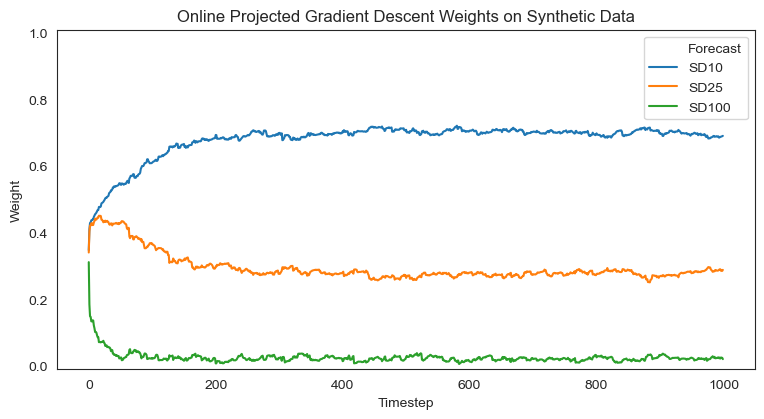

In [40]:
test1ogd_df = pd.DataFrame(weights_ogd, columns = ['SD10', 'SD25', 'SD100'])
test1ogd_df['Timestep'] = list(range(iters))
test1ogd_df = test1ogd_df.melt(id_vars=['Timestep'], var_name = 'Forecast', value_name = 'Weight')

sns.set_style("white")
plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams['figure.dpi'] = 100
plt.ylim(-0.01, 1.01)
plt.title('Online Projected Gradient Descent Weights on Synthetic Data')
plt.legend(loc='upper left')

ax = sns.lineplot(x='Timestep', y='Weight', hue = 'Forecast', data=test1ogd_df)
plt.savefig('data/figures/test1ogd.png')



No handles with labels found to put in legend.


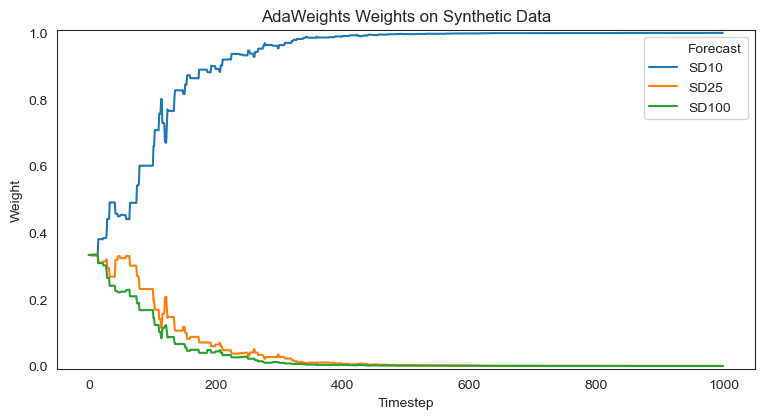

In [41]:
test1ada_df = pd.DataFrame(weights_ada, columns = ['SD10', 'SD25', 'SD100'])
test1ada_df['Timestep'] = list(range(iters))
test1ada_df = test1ada_df.melt(id_vars=['Timestep'], var_name = 'Forecast', value_name = 'Weight')

sns.set_style("white")
plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams['figure.dpi'] = 100
plt.title('AdaWeights Weights on Synthetic Data')
plt.ylim(-0.01, 1.01)
plt.legend(loc='upper left')

ax = sns.lineplot(x='Timestep', y='Weight', hue = 'Forecast', data=test1ada_df)
plt.savefig('data/figures/test1ada.png')

In [5]:
### Test 2

# Generate synthetic forecasts
def get_normal(loc, scale):
    return np.random.normal(loc, scale, (1,))[0]

iters = 1000
num_fcsts = 3
forecasts = np.zeros((iters, num_fcsts))
actual = np.zeros((iters,))
for i in range(iters):
    forecasts[i:i+1] = np.array([get_normal(1000, 25), get_normal(1000, 25), get_normal(1000, 25)])
    actual[i] = 1000

# Apply AdaWeighting and Gradient Descent for each generated forecast timestep
weights_ogd = online_grad_descent(forecasts, actual.reshape(iters, 1))
weights_ada = ada_weighting(forecasts, actual.reshape(iters, 1))


No handles with labels found to put in legend.


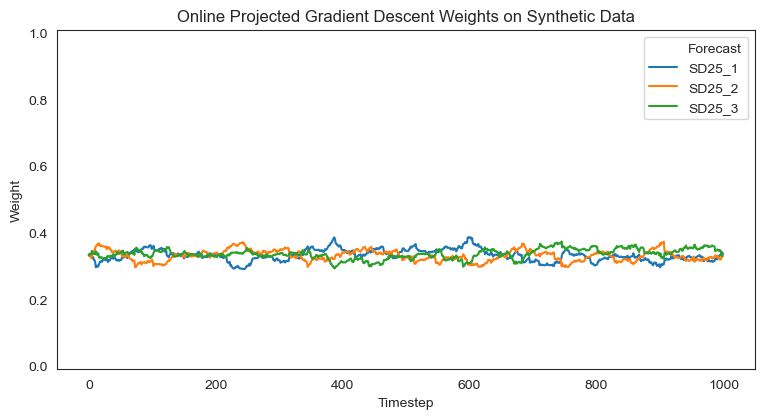

In [8]:
test1ogd_df = pd.DataFrame(weights_ogd, columns = ['SD25_1', 'SD25_2', 'SD25_3'])
test1ogd_df['Timestep'] = list(range(iters))
test1ogd_df = test1ogd_df.melt(id_vars=['Timestep'], var_name = 'Forecast', value_name = 'Weight')

sns.set_style("white")


plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams['figure.dpi'] = 100
plt.legend(loc='upper left')
plt.ylim(-0.01, 1.01)
plt.title('Online Projected Gradient Descent Weights on Synthetic Data')

ax = sns.lineplot(x='Timestep', y='Weight', hue = 'Forecast', data=test1ogd_df)
plt.savefig('data/figures/test2ogd.png')


No handles with labels found to put in legend.


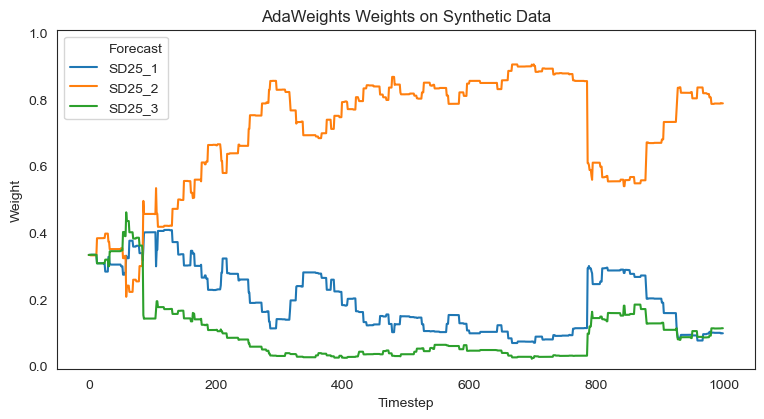

In [10]:
test1ada_df = pd.DataFrame(weights_ada, columns = ['SD25_1', 'SD25_2', 'SD25_3'])
test1ada_df['Timestep'] = list(range(iters))
test1ada_df = test1ada_df.melt(id_vars=['Timestep'], var_name = 'Forecast', value_name = 'Weight')

sns.set_style("white")
plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams['figure.dpi'] = 100
plt.legend(loc='upper left')
plt.ylim(-0.01, 1.01)
plt.title('AdaWeights Weights on Synthetic Data')

ax = sns.lineplot(x='Timestep', y='Weight', hue = 'Forecast', data=test1ada_df)
plt.savefig('data/figures/test2ada.png')